In [ ]:
import numpy as np
import cv2
import json
import copy
import sklearn
import skimage.io
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from skimage.segmentation import slic

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
with open('/gdrive/MyDrive/SeCAM/imagenet_labelmap.json') as labels_file:
    labels_file = json.load(labels_file)

In [ ]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(mask_image(z, segments_slic, img_array, 255))

In [ ]:
def returnCAM(feature_conv, weight_softmax, class_idx):

  #start = timeit.default_timer()

  size_upsample = (WIDTH, HEIGHT)

  # Keras default is channels last, hence nc is in last
  bz, h, w, nc = feature_conv.shape
  # feature_cov.shape : (1, 7, 7, 2048)
  print('feature_cov.shape :', feature_conv.shape)
  output_cam = []
  for idx in class_idx:
      cam = np.dot(weight_softmax[:, idx], np.transpose(feature_conv.reshape(h*w, nc)))
      cam = cam.reshape(h, w)
      cam = cam - np.min(cam)
      cam_img = cam / np.max(cam)
      cam_img = np.uint8(255 * cam_img)
      print('-------------------')
      print('cam_img.shape: ', cam_img.shape)
      print('-------------------')
      output_cam.append(cv2.resize(cam_img, size_upsample))

  #stop = timeit.default_timer()

  #print('Time CAM: ', stop - start)

  return output_cam

In [ ]:
def compute_cam_values(cam_output, superpixels):
  max_superpixels = np.max(superpixels)
  cam = cam_output
  cam_values = np.zeros(n_segments)
  count = np.zeros(n_segments)
  for i in range(WIDTH):
    for j in range(HEIGHT):
      index_superpixels = superpixels[i][j]
      cam_values[index_superpixels] += cam[i][j]
      count[index_superpixels] += 1
  for i in range (n_segments):
    cam_values[i] /= count[i]

  CAMs_segment = copy.copy(superpixels)
  for i in range (WIDTH):
    for j in range(HEIGHT):
      index_superpixels = segments_slic[i][j]
      CAMs_segment[i][j] = cam_values[index_superpixels]

  for i in range(n_segments):
    if i > max_superpixels:
      cam_values[i] =0

  return cam_values,CAMs_segment

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

In [ ]:
def predictions(model):
  model = model
  probs_extractor = K.function([model.input], [model.output])
  prob = probs_extractor([np.expand_dims(img_array, 0)])[0]
  idx = np.argsort(prob)
  probs = np.sort(prob)
  for i in range(-1, -6, -1):
    print('{:.3f} -> {}'.format(probs[0, i], labels_file[str(idx[0, i])]))
  return prob, probs_extractor

In [ ]:
def seCAM(CAM, segments):
  cam = CAM
  superpixels = segments
  max_superpixels = np.max(superpixels)
  cam_values = np.zeros(n_segments)
  count = np.zeros(n_segments)
  cam_values, CAMs_segment = compute_cam_values(cam, superpixels)
  CAMs_segment -= np.min(CAMs_segment)

  CAMs_segment_image = CAMs_segment / np.max(CAMs_segment)

  argsort_cam = np.argsort(cam_values)

  index_segments_cam = []

  for i in range(num_top_features):
    index_segments_cam.append(argsort_cam[-i-1])

  index_segments_cam = np.array(index_segments_cam)

  mask_secam = np.zeros(n_segments)
  mask_secam[index_segments_cam] = True #Activate top superpixels
  Xi = skimage.io.imread(image_path)
  Xi = skimage.transform.resize(Xi, (HEIGHT, WIDTH))
  image_cam = perturb_image(Xi,mask_secam,segments_slic)

  skimage.io.imshow(perturb_image(Xi,mask_secam,segments_slic))
  return image_cam

Main

In [ ]:
model_name = "resnet50"

n_segments = 49 #number of segments (superpixels) that splitted from the input image
n_examples = 1000 #number of examples that used for the calculation in LIME, SHAP
num_top_features = 4
thresholds = 0.8

In [ ]:
if model_name == "resnet50":
  HEIGHT = 224
  WIDTH = 224
  model = applications.ResNet50(include_top=True)
  finalconv_name = 'conv5_block3_out'
  from tensorflow.keras.applications.resnet50 import preprocess_input
if model_name == "inceptionv3":
  HEIGHT = 299
  WIDTH = 299
  model = applications.InceptionV3(include_top=True)
  finalconv_name = 'mixed10'
  from tensorflow.keras.applications.inception_v3 import preprocess_input


102973440/102967424 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#finalconv_name = 'conv5_block3_out' #Usig model.summary() and get the layer preceding the GAP (GlobalAveragePooling2) layer as the finalconv_name
# Get the layer of the last conv layer
fianlconv = model.get_layer(finalconv_name)

In [ ]:
weight_softmax = model.layers[-1].get_weights()[0]
print(weight_softmax.shape)

(2048, 1000)


In [ ]:
image_path = '/gdrive/MyDrive/SeCAM/Input_Image/hummingbird.jpg'
image = load_img(image_path, target_size=(HEIGHT, WIDTH))
img_array = img_to_array(image)
#The preprocess_input function is meant to adequate your image to the format the model requires
img_array = preprocess_input(img_array)

segments_slic = slic(image, n_segments= n_segments, compactness=30, sigma=3)

probs, probs_extractor = predictions(model)

features_conv_extractor = K.function([model.input], [fianlconv.output])

 # Get dictionary of classes from LABELS_URL
classes = labels_file
features_blob = features_conv_extractor([np.expand_dims(img_array, 0)])[0]

0.974 -> hummingbird
0.020 -> jacamar
0.004 -> coucal
0.000 -> bee_eater
0.000 -> kite


In [ ]:
features_blobs = []
features_blobs.append(features_blob)

idx = np.argsort(probs)
probs = np.sort(probs)

In [ ]:
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0, -1]])
cam = CAMs[0]

feature_cov.shape : (1, 7, 7, 2048)
-------------------
cam_img.shape:  (7, 7)
-------------------


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

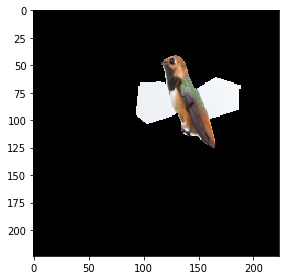

In [ ]:
seCAM(cam, segments_slic)

(224, 224)

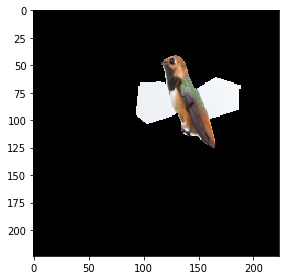

In [ ]:
import PIL
x = seCAM(cam, segments_slic)
img=PIL.Image.fromarray((x * 255).astype(np.uint8))
img.size

In [ ]:
img.save("/gdrive/MyDrive/SeCAM/SeCAM_image/hummingbird_secam.jpg")

In [ ]:
cd "/gdrive/MyDrive/SeCAM/"

/gdrive/MyDrive/SeCAM


In [ ]:
!python "main.py"

2021-04-23 03:45:40.793164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-23 03:45:47.429032: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-23 03:45:47.429898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-23 03:45:47.444780: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-23 03:45:47.444857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b136724cf86a): /proc/driver/nvidia/version does not exist
2021-04-23 03:45:47.445375: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
96116736/96112376 [==============================] - 2s 0us/step
Traceback (

In [ ]:
import torch
from torch.autograd import Function
from torchvision import models, transforms
model1 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
model1 = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
model1.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import argparse


In [ ]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='./content/both.png',
                        help='Input image path')
    args = parser.parse_args(''.split())
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args


In [ ]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda

        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


In [ ]:
args = get_args()

Using CPU for computation


In [ ]:
class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


In [ ]:
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

In [ ]:
grad_cam1 = GradCam(model=model1, feature_module=model1.features, \
                       target_layer_names=["MaxPool2d"], use_cuda=args.use_cuda)

In [ ]:
def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [ ]:
img = cv2.imread(image_path)
img = cv2.resize(img, (WIDTH, HEIGHT))
img = np.float32(img) / 255
img = img[:,:,::-1]
input_img = preprocess_image(img)
target_category = None
grayscale_cam1 = grad_cam1(input_img, target_category)

IndexError: ignored

In [ ]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
grayscale_cam1 = cv2.resize(grayscale_cam1, (WIDTH, HEIGHT))
cam1 = show_cam_on_image(img, grayscale_cam1)

In [ ]:
cam_mask1 = cv2.merge([grayscale_cam1, grayscale_cam1, grayscale_cam1])

In [ ]:
cv2.imwrite("cam_vgg.jpg", cam1)

True

In [ ]:
predict = model1(input_img)

In [ ]:
torch.argmax(predict)

tensor(92)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

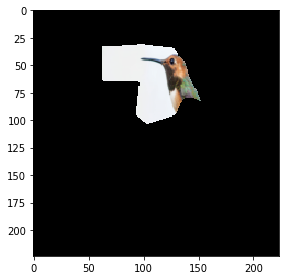

In [ ]:
seCAM(grayscale_cam1, segments_slic)